In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

(classification_decision_making)=
# Decision making

## Objectives

+ To demonstrate how to use the results of a binary classifier to make decisions

## High melting explosives sensitivity
Let's repeat what we did for the HMX example, but after splitting the dataset into training and validation subsets.
We will be making predictions on the validation subset.

In [2]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/hmx_data.csv"
download(url)

import pandas as pd
data = pd.read_csv('hmx_data.csv')
x = data['Height'].values
label_coding = {'E': 1, 'N': 0}
y = np.array([label_coding[r] for r in data['Result']])
data['y'] = y
data.head()

,Height,Result,y
0,40.5,E,1
1,40.5,E,1
2,40.5,E,1
3,40.5,E,1
4,40.5,E,1


Separate data into training and validation:

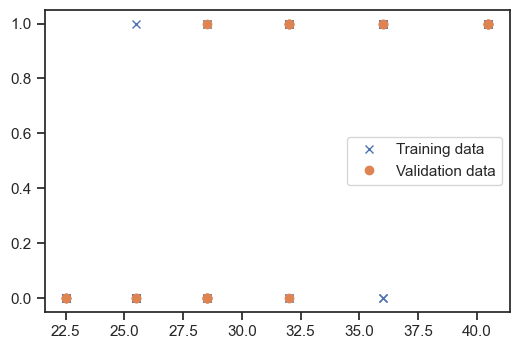

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)

num_obs = x.shape[0]

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
plt.legend(loc='best');

Train the model:

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Design matrix
poly = PolynomialFeatures(2)
Phi = poly.fit_transform(x[:, None])

# Fit
model = LogisticRegression(
    penalty='none',
    fit_intercept=False
).fit(Phi, y)

Make probabilistic predictions on the validation data:

In [5]:
Phi_valid = poly.fit_transform(x_valid[:, None])
predictions = model.predict_proba(Phi_valid)
print('x\tp(y=0|x)\tp(y=1|x)\tTrue label')
print('-' * 80)
for i in range(x_valid.shape[0]):
    print(
        f"{x_valid[i]:1.2f}\t"
        + f"{predictions[i, 0]:1.2f}\t\t"
        + f"{predictions[i, 1]:1.2f}\t\t"
        + f"{y_valid[i]:d}"
    )

x	p(y=0|x)	p(y=1|x)	True label
--------------------------------------------------------------------------------
36.00	0.10		0.90		1
40.50	0.01		0.99		1
25.50	0.88		0.12		0
22.50	0.93		0.07		0
28.50	0.75		0.25		0
28.50	0.75		0.25		0
22.50	0.93		0.07		0
32.00	0.43		0.57		1
40.50	0.01		0.99		1
40.50	0.01		0.99		1
28.50	0.75		0.25		0
32.00	0.43		0.57		0
28.50	0.75		0.25		0
22.50	0.93		0.07		0
40.50	0.01		0.99		1
25.50	0.88		0.12		0
32.00	0.43		0.57		1
36.00	0.10		0.90		1
28.50	0.75		0.25		1
32.00	0.43		0.57		1


And here is a nice way to visualize these probabilities:

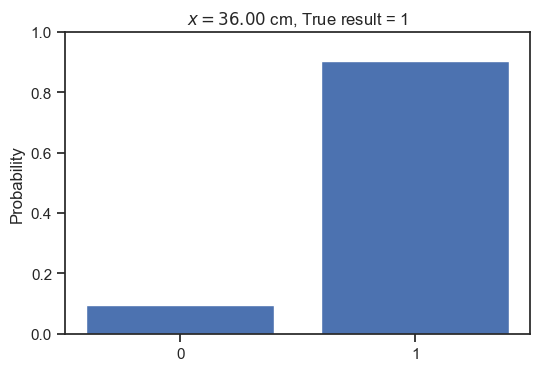

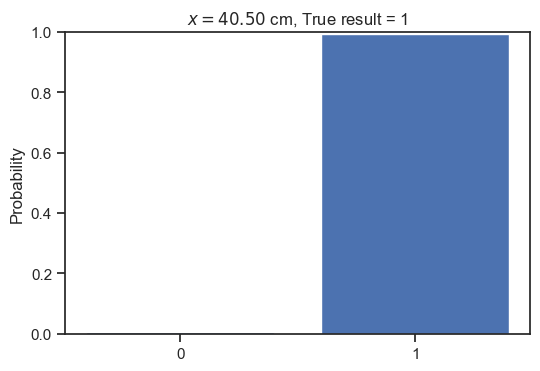

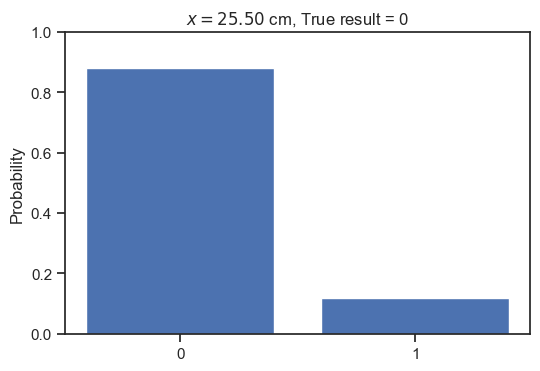

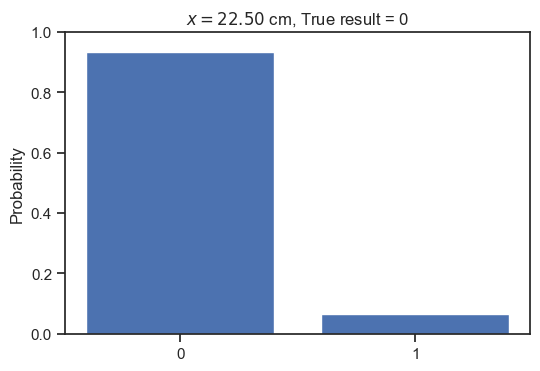

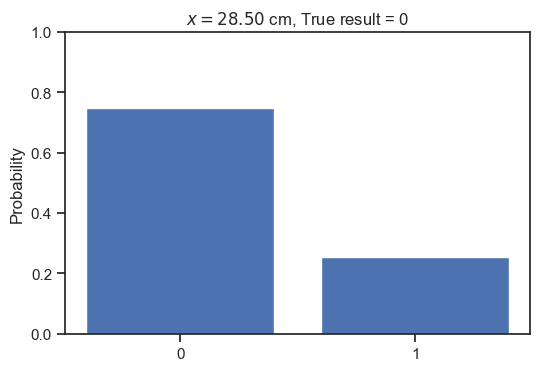

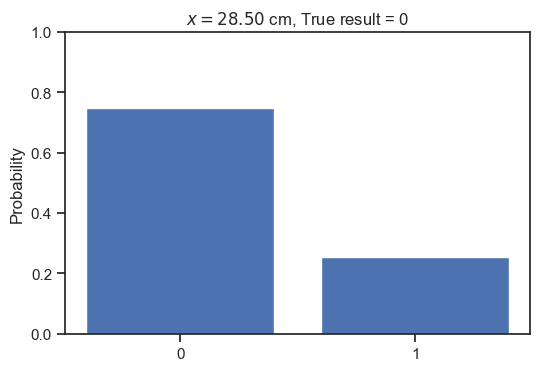

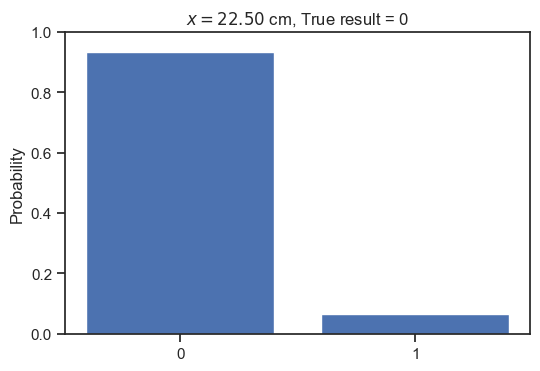

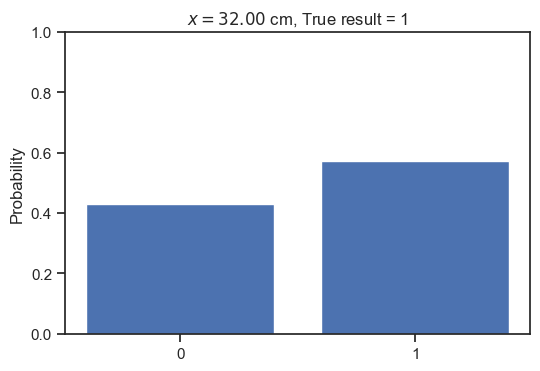

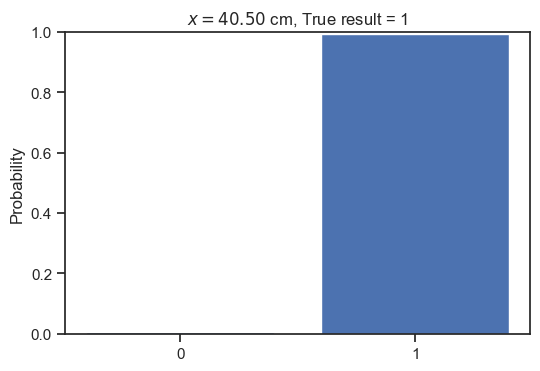

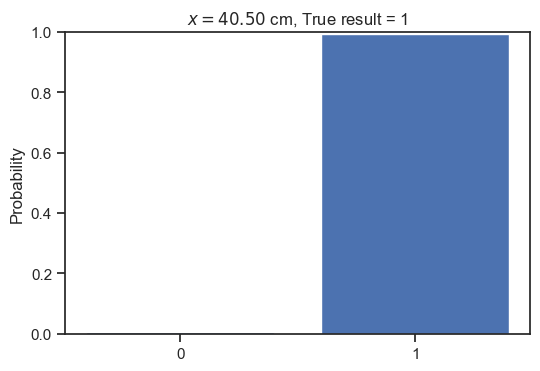

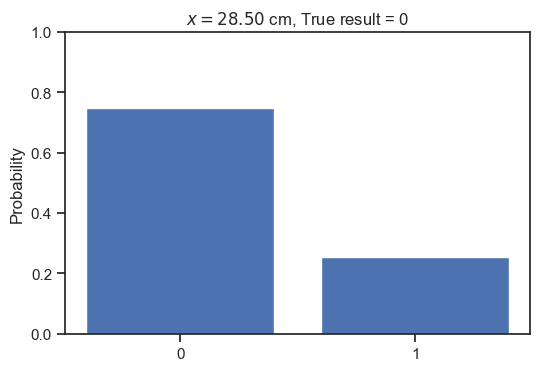

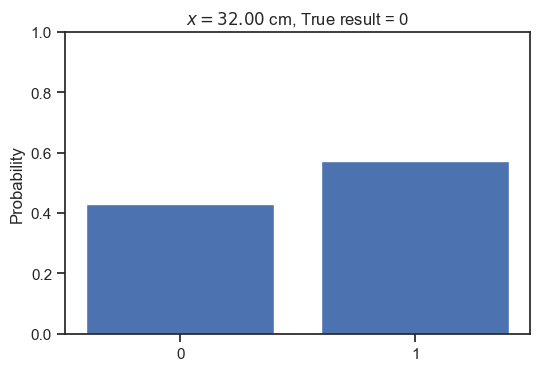

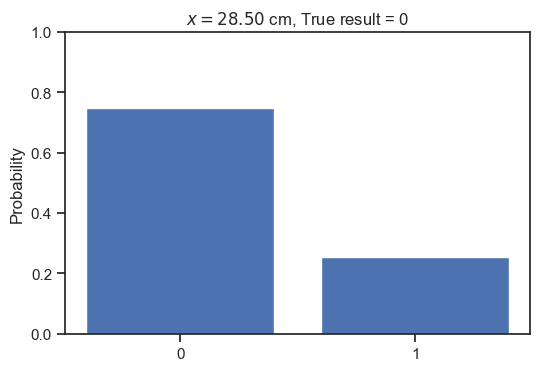

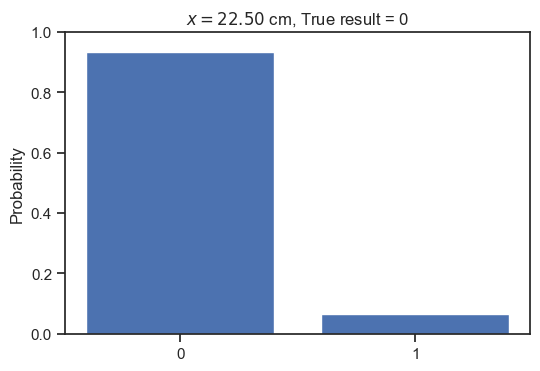

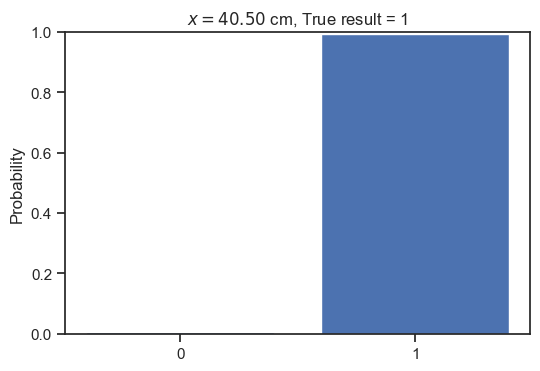

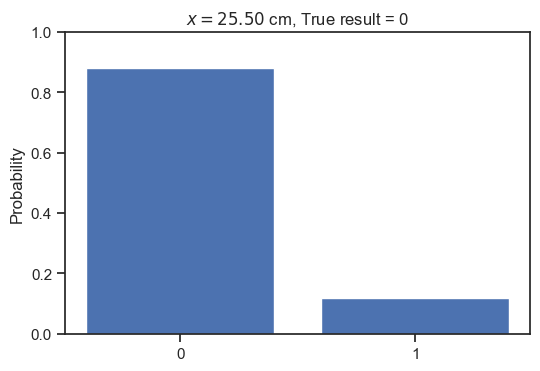

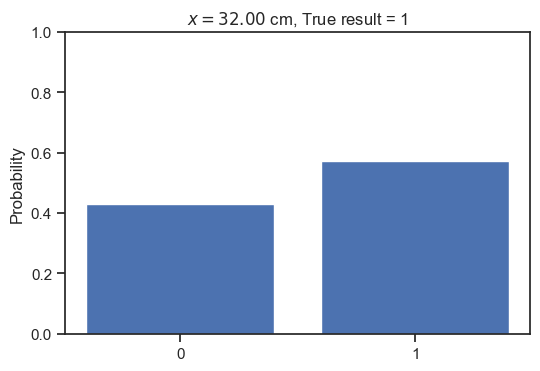

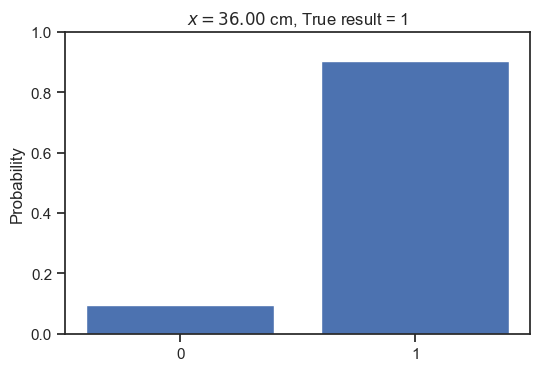

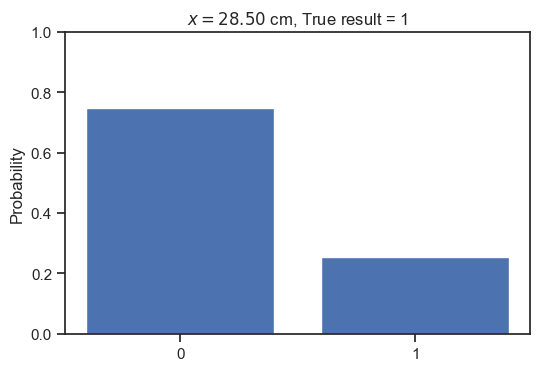

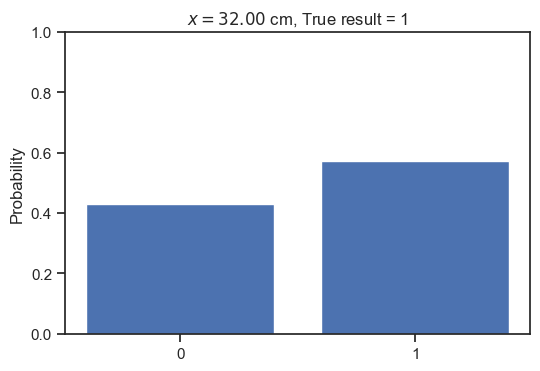

In [6]:
for i in range(x_valid.shape[0]):
    fig, ax = plt.subplots()
    ax.bar(np.arange(2), predictions[i])
    ax.set_title(f'$x={x_valid[i]:1.2f}$ cm, True result = {y_valid[i]:d}')
    ax.set_ylim([0, 1.0])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(model.classes_)
    ax.set_ylabel('Probability')

Now we are ready to pose and solve the decision-making problem.
We just need to define a cost matrix:

In [7]:
# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true
cost_matrix = np.array(
    [
        [0.0, 1.0],
        [1.0, 0.0]
    ]
)

Here is some code that computes the expected cost of each choice given the predicted probabilities:

In [8]:
def expected_cost(cost_matrix, prediction_prob):
    """Calculate the expected cost of each decision.
    
    Arguments
    cost_matrix     --  A D x D matrix. `cost_matrix[i, j]`
                        is the cost of picking `i` and then
                        `j` happens.
    prediction_prob --  An array with D elements containing
                        the probability that each event
                        happens.
    """
    assert cost_matrix.ndim == 2
    D = cost_matrix.shape[0]
    assert cost_matrix.shape[1] == D
    assert prediction_prob.ndim == 1
    assert prediction_prob.shape[0] == D
    res = np.zeros((2,))
    for i in range(2):
        res[i] = (
            cost_matrix[i, 0] * prediction_prob[0]
            + cost_matrix[i, 1] * prediction_prob[1]
        )
    return res

As a demonstration, here is the expected cost of each decision for the first few validation points.
We will put a star (\*) next to the choice with minimum cost.

In [9]:
print('x\tCost of 0\tCost of 1\tTrue label\tChoice')
print('-' * 80)
for i in range(x_valid.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions[i])
    line = f'{x_valid[i]:1.2f}\t{exp_c[0]:1.2f}'
    tmp = f'\t\t{exp_c[1]:1.2f}'
    correct_choice = True
    if exp_c[0] < exp_c[1]:
        line += '*'
        if y_valid[i] == 1:
            correct_choice = False
    else:
        tmp += '*'
        if y_valid[i] == 0:
            correct_choice = False
    line += tmp + f'\t\t{y_valid[i]}'
    if correct_choice:
        line += '\t\tCORRECT'
    else:
        line += '\t\tWRONG'
    print(line)

x	Cost of 0	Cost of 1	True label	Choice
--------------------------------------------------------------------------------
36.00	0.90		0.10*		1		CORRECT
40.50	0.99		0.01*		1		CORRECT
25.50	0.12*		0.88		0		CORRECT
22.50	0.07*		0.93		0		CORRECT
28.50	0.25*		0.75		0		CORRECT
28.50	0.25*		0.75		0		CORRECT
22.50	0.07*		0.93		0		CORRECT
32.00	0.57		0.43*		1		CORRECT
40.50	0.99		0.01*		1		CORRECT
40.50	0.99		0.01*		1		CORRECT
28.50	0.25*		0.75		0		CORRECT
32.00	0.57		0.43*		0		WRONG
28.50	0.25*		0.75		0		CORRECT
22.50	0.07*		0.93		0		CORRECT
40.50	0.99		0.01*		1		CORRECT
25.50	0.12*		0.88		0		CORRECT
32.00	0.57		0.43*		1		CORRECT
36.00	0.90		0.10*		1		CORRECT
28.50	0.25*		0.75		1		WRONG
32.00	0.57		0.43*		1		CORRECT


Notice that most of the choices are correct. But there are some wrong choices.
The particularly bad wrong choices are the ones where we predict 0 (no explosion), but there is actually an explosion. Are there any such cases?

Let me now show you another very nice way to compute the expected cost for all the validation points in one line.
This is using the [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) function (Einstein summation convention).
It takes a while to understand what it does, but if you do you can shorten by a lot your linear algebra code.
The idea is that repeated indices are summed over.

In [10]:
exp_cost = np.einsum('ij,kj->ki', cost_matrix, predictions)
print(exp_cost)

[[0.904 0.096]
 [0.993 0.007]
 [0.12  0.88 ]
 [0.065 0.935]
 [0.253 0.747]
 [0.253 0.747]
 [0.065 0.935]
 [0.571 0.429]
 [0.993 0.007]
 [0.993 0.007]
 [0.253 0.747]
 [0.571 0.429]
 [0.253 0.747]
 [0.065 0.935]
 [0.993 0.007]
 [0.12  0.88 ]
 [0.571 0.429]
 [0.904 0.096]
 [0.253 0.747]
 [0.571 0.429]]


Here is yet another way to visualize the decisions of binary classification:

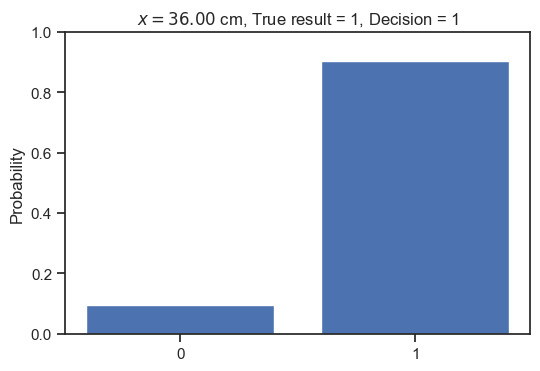

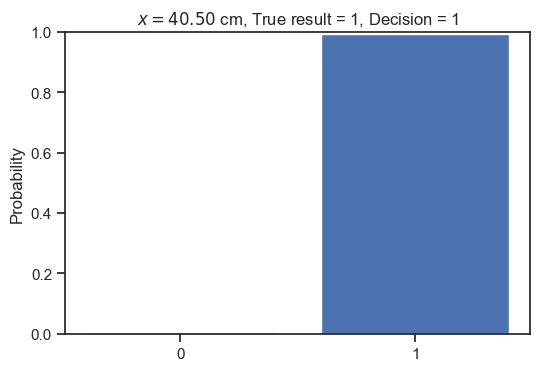

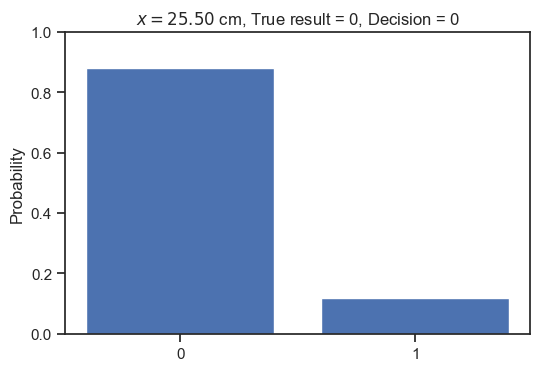

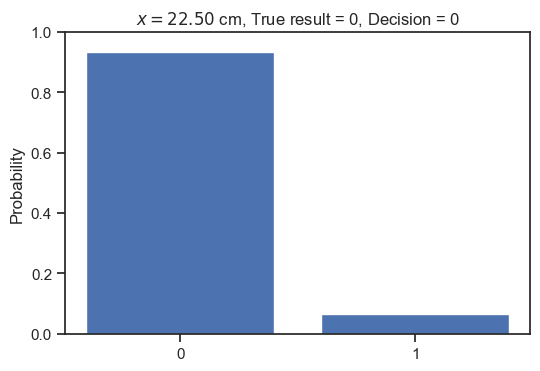

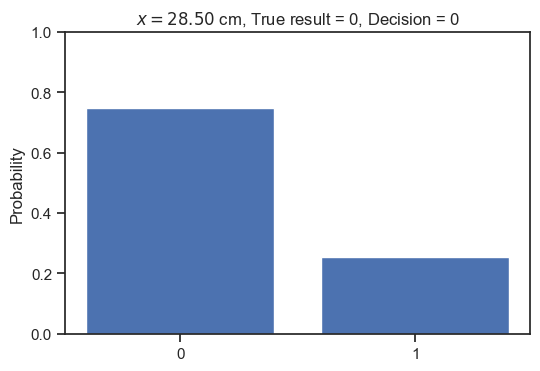

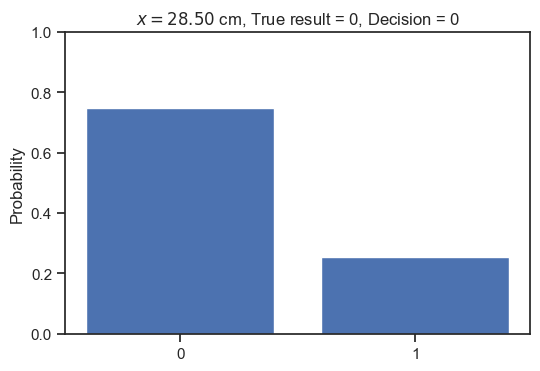

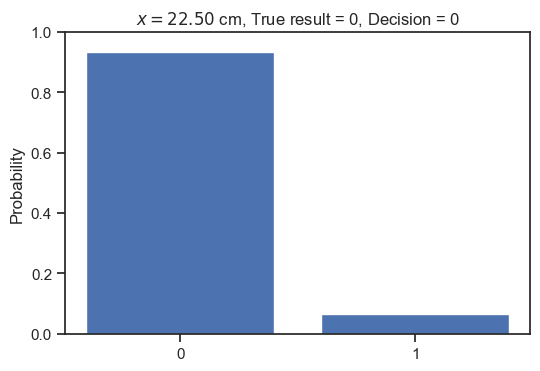

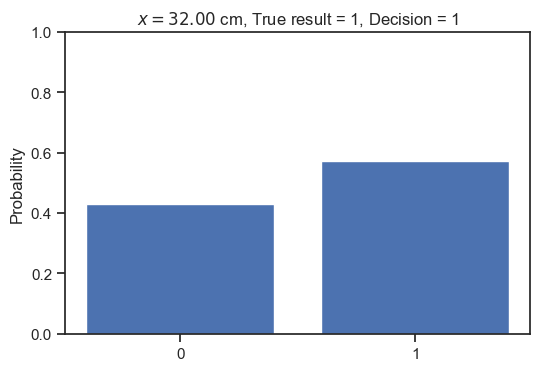

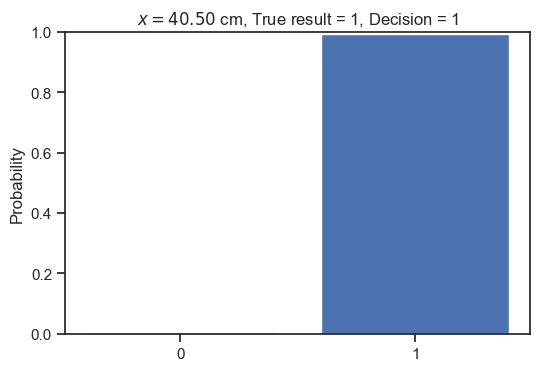

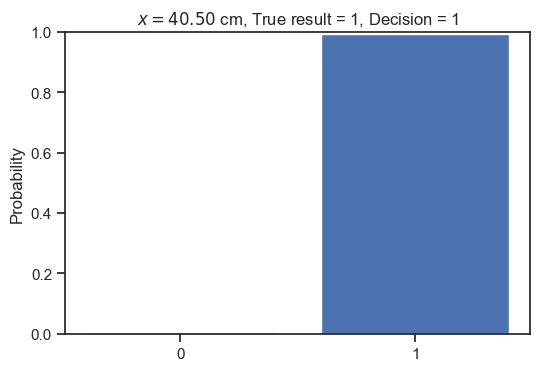

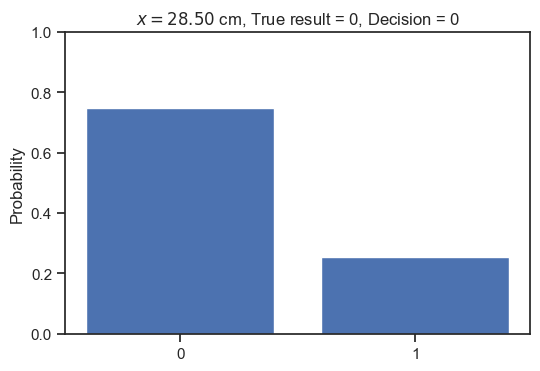

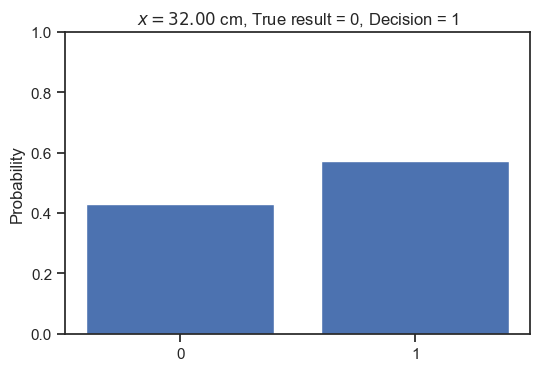

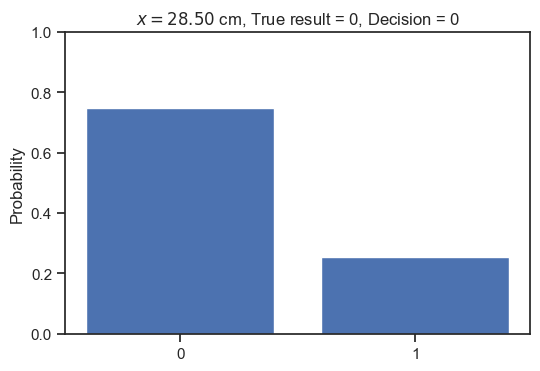

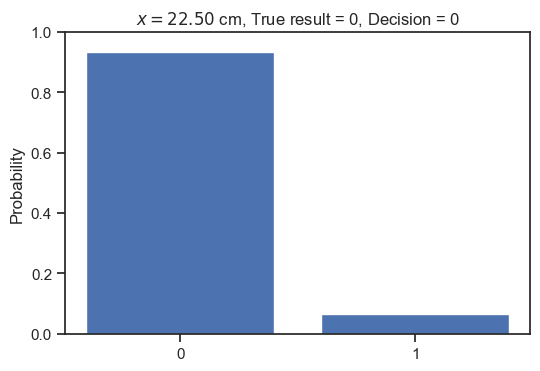

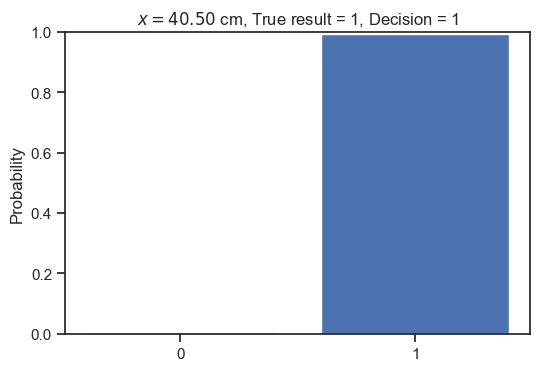

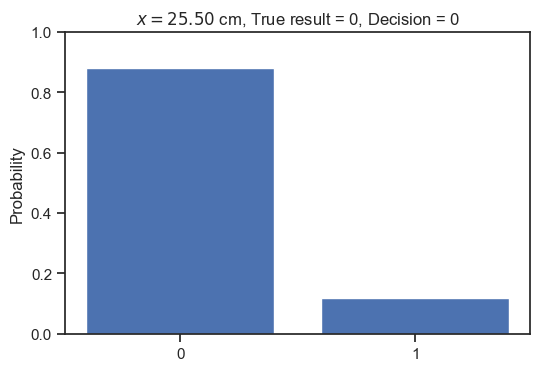

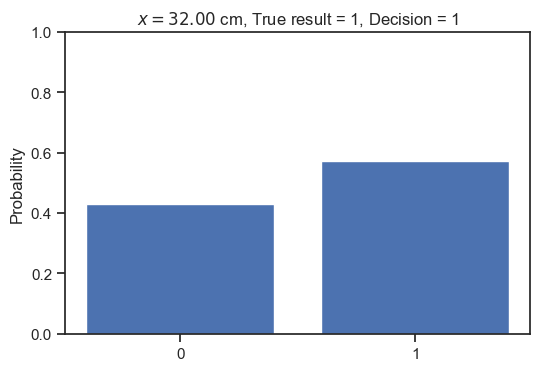

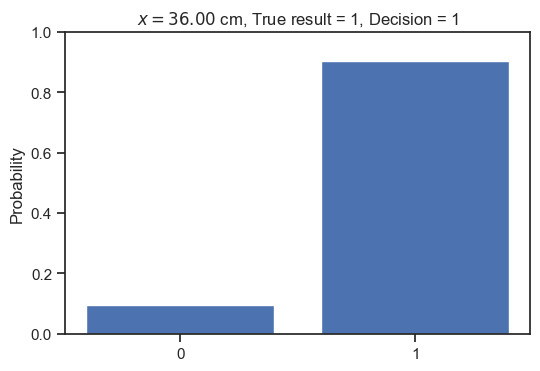

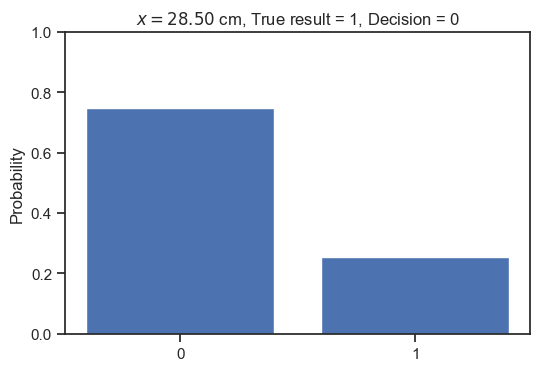

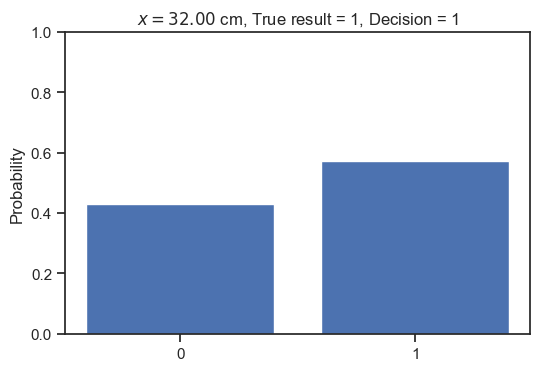

In [11]:
for i in range(x_valid.shape[0]):
    # Make decision
    decision = model.classes_[np.argmin(exp_cost[i])]
    fig, ax = plt.subplots()
    ax.bar(np.arange(2), predictions[i])
    ax.set_title(
        f'$x={x_valid[i]:1.2f}$ cm, '
        + f'True result = {y_valid[i]:d}, '
        + f'Decision = {decision:d}'
    )
    ax.set_ylim([0, 1.0])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(model.classes_)
    ax.set_ylabel('Probability');

Now let's plot the decision boundary of our model:

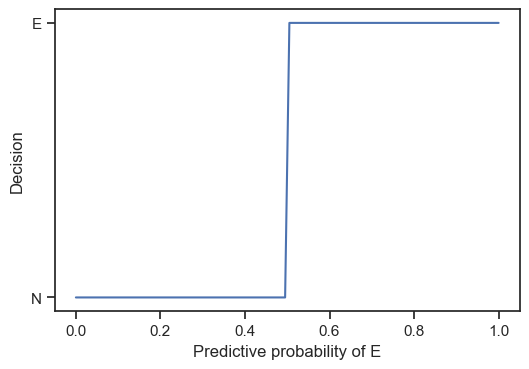

In [12]:
fig, ax = plt.subplots()
pE = np.linspace(0, 1, 100)
pN = 1.0 - pE
probs = np.hstack([pN[:, None], pE[:, None]])
exp_cost = np.einsum('ij,kj->ki', cost_matrix, probs)
decision_idx = np.argmin(exp_cost, axis=1)
ax.plot(pE, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['N', 'E'])
ax.set_ylabel('Decision')
ax.set_xlabel('Predictive probability of E');

### Questions

+ Repeat the analysis above with a different cost matrix that penalizes more calling a non-explosion when there is an explosion.